In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pickle
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import random
import itertools
import re
import torch.optim as optim
from scipy.stats import spearmanr
from transformers import AutoTokenizer, AutoModel

In [ ]:
class ConvStem1D(nn.Module):
    def __init__(self, d_esm, d_model, n_conv=2, hidden_channels=[128, 256], kernel_sizes=[7,3], strides=[2,2]):
        super().__init__()
        layers = []
        in_c = d_esm
        for i in range(n_conv):
            out_c = hidden_channels[i] if i < len(hidden_channels) else d_model
            k = kernel_sizes[i]
            s = strides[i]
            layers.append(nn.Conv1d(in_c, out_c, kernel_size=k, stride=s, padding=k//2, bias=False))
            layers.append(nn.BatchNorm1d(out_c))
            layers.append(nn.ReLU(inplace=True))
            in_c = out_c
        self.conv = nn.Sequential(*layers)
        self.out_dim = in_c

    def forward(self, x):  # x: (N, L, d_esm)
        x = x.permute(0, 2, 1)  # (N, d_esm, L)
        x = self.conv(x)         # (N, C, L')
        x = x.permute(0, 2, 1)   # (N, L', C)
        return x

class TransformerBlock1D(nn.Module):
    def __init__(self, d_model, nhead=4, dim_ff=1024, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.attn   = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.norm2  = nn.LayerNorm(d_model)
        self.ff     = nn.Sequential(
            nn.Linear(d_model, dim_ff),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(dim_ff, d_model),
            nn.Dropout(dropout)
        )

    def forward(self, x):  # x: (N, L, d_model)
        y = self.norm1(x)
        q = self.q_proj(y).transpose(0,1)
        k = self.k_proj(y).transpose(0,1)
        v = self.v_proj(y).transpose(0,1)
        y2, _ = self.attn(q, k, v)
        x = x + y2.transpose(0,1)
        y = self.norm2(x)
        x = x + self.ff(y)
        return x

class CT_Contrastive(nn.Module):
    def __init__(
        self,
        d_esm: int,
        d_model: int = 256,
        nhead: int = 4,
        dim_ff: int = 1024,
        num_transformer_blocks: int = 2,
        max_len: int = 101,
        use_first_fitness: bool = True,
        dropout_rate: float = 0.1,
        conv_hidden_channels=[128, 256],
        kernel_sizes=[7,3],
        strides=[2,2],
    ):
        super().__init__()
        self.use_first_fitness = use_first_fitness

        # CNN stem to compress input
        self.cnn_stem = ConvStem1D(d_esm, d_model, n_conv=len(conv_hidden_channels),
                                   hidden_channels=conv_hidden_channels,
                                   kernel_sizes=kernel_sizes,
                                   strides=strides)
        # Positional Embedding
        self.pos_emb = nn.Embedding(max_len, d_model)

        # Transformer Blocks
        self.transformers = nn.Sequential(
            *[TransformerBlock1D(d_model, nhead, dim_ff, dropout_rate) for _ in range(num_transformer_blocks)]
        )

        # Global pooling + final FC
        self.pool = nn.AdaptiveAvgPool1d(1)
        fc_in = d_model + (1 if use_first_fitness else 0)
        self.fc  = nn.Linear(fc_in, 1)

    def forward(self, emb1, emb2, fit1=None):
        x = emb2 - emb1  # (N, L, d_esm)
        x = self.cnn_stem(x)  # (N, L', d_model)
        N, L, _ = x.shape
        pos = torch.arange(L, device=x.device).unsqueeze(0)
        x = x + self.pos_emb(pos)
        x = self.transformers(x)
        x = self.pool(x.transpose(1,2)).squeeze(-1)  # (N, d_model)
        if self.use_first_fitness and fit1 is not None:
            x = torch.cat([x, fit1], dim=1)
        return self.fc(x).squeeze(-1)

In [ ]:
def load_data(idx1, idx2, fit1, labels, emb, batch, batch_size, device):
    """
    Returns:
      emb1_batch: (B, L, d_esm) torch.Tensor
      emb2_batch: (B, L, d_esm) torch.Tensor
      fit1_batch: (B, 1)      torch.Tensor
      labels_batch:(B,)       torch.Tensor
    """
    start = batch * batch_size
    end   = min(start + batch_size, len(labels))
    b_idx1 = idx1[start:end]
    b_idx2 = idx2[start:end]
    b_fit1 = np.array(fit1[start:end], dtype=np.float32).reshape(-1,1)
    b_lbl  = np.array(labels[start:end], dtype=np.float32).reshape(-1,1)

    emb1 = emb[np.array(b_idx1)]
    emb2 = emb[np.array(b_idx2)]
    emb1 = torch.from_numpy(emb1).float().to(device)
    emb2 = torch.from_numpy(emb2).float().to(device)
    fit1 = torch.from_numpy(b_fit1).float().to(device)
    lbl  = torch.from_numpy(b_lbl).squeeze(1).float().to(device)
    return emb1, emb2, fit1, lbl


def train_epoch(model, optimizer, idx1, idx2, fit1, labels, emb, batch_size, epoch, device, train_frac):
    model.train()
    criterion = nn.MSELoss()
    running_loss = 0.0
    total = 0
    num_batches = math.ceil(len(labels) / batch_size)
    batch_set_size = math.ceil(num_batches/train_frac)
    batch_set_idx = (epoch-1)%train_frac
    start_b = batch_set_idx * batch_set_size
    end_b = (batch_set_idx+1) * batch_set_size
    for b in tqdm(list(range(num_batches))[start_b: end_b], desc=f"Epoch {epoch}"):
        e1, e2, f1, y = load_data(idx1, idx2, fit1, labels, emb, b, batch_size, device)
        preds = model(e1, e2, f1)
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * preds.size(0)
        total += preds.size(0)
    return running_loss / total


def test_epoch(model, idx1, idx2, fit1, labels, emb, batch_size, epoch, device, test_frac=None):
    model.eval()
    criterion = nn.MSELoss()
    running_loss = 0.0
    total = 0
    all_preds = []
    all_targets = []
    num_batches = math.ceil(len(labels) / batch_size)
    b_set = list(range(num_batches))
    if test_frac:
        b_set = random.sample(range(num_batches), math.ceil(num_batches/test_frac))
    with torch.no_grad():
        for b in tqdm(b_set, desc=f"Epoch {epoch}"):
            e1, e2, f1, y = load_data(idx1, idx2, fit1, labels, emb, b, batch_size, device)
            preds = model(e1, e2, f1)
            loss = criterion(preds, y)
            running_loss += loss.item() * preds.size(0)
            total += preds.size(0)
            all_preds.append(preds.detach().cpu().numpy())
            all_targets.append(y.detach().cpu().numpy())
    avg_loss = running_loss / total
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    corr, _ = spearmanr(all_preds, all_targets)
    return avg_loss, corr, all_preds, all_targets

# Re-train the CT_Contrastive model on the entire dataset

Epoch 1: 100%|██████████| 5954/5954 [07:02<00:00, 14.08it/s]


Epoch   1 ▶ Train Loss 2.5510


Epoch 2: 100%|██████████| 5954/5954 [06:42<00:00, 14.81it/s]


Epoch   2 ▶ Train Loss 3.4678


Epoch 3: 100%|██████████| 5954/5954 [06:44<00:00, 14.73it/s]


Epoch   3 ▶ Train Loss 2.3251


Epoch 4: 100%|██████████| 5954/5954 [06:54<00:00, 14.37it/s]


Epoch   4 ▶ Train Loss 2.8036


Epoch 5: 100%|██████████| 5954/5954 [06:56<00:00, 14.28it/s]


Epoch   5 ▶ Train Loss 1.8967


Epoch 6: 100%|██████████| 5954/5954 [07:03<00:00, 14.07it/s]


Epoch   6 ▶ Train Loss 1.5252


Epoch 7: 100%|██████████| 5954/5954 [07:26<00:00, 13.34it/s]


Epoch   7 ▶ Train Loss 1.3340


Epoch 8: 100%|██████████| 5954/5954 [07:19<00:00, 13.55it/s]


Epoch   8 ▶ Train Loss 1.1989


Epoch 9: 100%|██████████| 5954/5954 [07:13<00:00, 13.73it/s]


Epoch   9 ▶ Train Loss 1.1045


Epoch 10: 100%|██████████| 5954/5954 [07:11<00:00, 13.79it/s]


Epoch  10 ▶ Train Loss 1.0180


Epoch 11: 100%|██████████| 5954/5954 [07:10<00:00, 13.84it/s]


Epoch  11 ▶ Train Loss 0.9519


Epoch 12: 100%|██████████| 5954/5954 [07:31<00:00, 13.19it/s]


Epoch  12 ▶ Train Loss 0.9007


Epoch 13: 100%|██████████| 5954/5954 [07:06<00:00, 13.96it/s]


Epoch  13 ▶ Train Loss 0.8523


Epoch 14: 100%|██████████| 5954/5954 [07:07<00:00, 13.94it/s]


Epoch  14 ▶ Train Loss 0.8129


Epoch 15: 100%|██████████| 5954/5954 [07:25<00:00, 13.35it/s]


Epoch  15 ▶ Train Loss 0.7762


Epoch 16: 100%|██████████| 5954/5954 [07:36<00:00, 13.04it/s]


Epoch  16 ▶ Train Loss 0.7385


Epoch 17: 100%|██████████| 5954/5954 [07:12<00:00, 13.77it/s]


Epoch  17 ▶ Train Loss 0.7073


Epoch 18: 100%|██████████| 5954/5954 [06:24<00:00, 15.50it/s]


Epoch  18 ▶ Train Loss 0.6869


Epoch 19: 100%|██████████| 5954/5954 [07:02<00:00, 14.08it/s]


Epoch  19 ▶ Train Loss 0.6584


Epoch 20: 100%|██████████| 5954/5954 [06:46<00:00, 14.65it/s]


Epoch  20 ▶ Train Loss 0.6307


Epoch 21: 100%|██████████| 5954/5954 [07:25<00:00, 13.37it/s]


Epoch  21 ▶ Train Loss 0.6127


Epoch 22: 100%|██████████| 5954/5954 [07:03<00:00, 14.06it/s]


Epoch  22 ▶ Train Loss 0.5917


Epoch 23: 100%|██████████| 5954/5954 [07:16<00:00, 13.64it/s]


Epoch  23 ▶ Train Loss 0.5769


Epoch 24: 100%|██████████| 5954/5954 [07:09<00:00, 13.85it/s]


Epoch  24 ▶ Train Loss 0.5571


Epoch 25: 100%|██████████| 5954/5954 [07:10<00:00, 13.82it/s]


Epoch  25 ▶ Train Loss 0.5411


Epoch 26: 100%|██████████| 5954/5954 [06:45<00:00, 14.67it/s]


Epoch  26 ▶ Train Loss 0.5226


Epoch 27: 100%|██████████| 5954/5954 [06:55<00:00, 14.31it/s]


Epoch  27 ▶ Train Loss 0.5121


Epoch 28: 100%|██████████| 5954/5954 [06:38<00:00, 14.95it/s]


Epoch  28 ▶ Train Loss 0.4930


Epoch 29: 100%|██████████| 5954/5954 [06:49<00:00, 14.55it/s]


Epoch  29 ▶ Train Loss 0.4867


Epoch 30: 100%|██████████| 5954/5954 [06:56<00:00, 14.30it/s]


Epoch  30 ▶ Train Loss 0.4714


Epoch 31: 100%|██████████| 5954/5954 [07:10<00:00, 13.83it/s]


Epoch  31 ▶ Train Loss 0.4585


Epoch 32: 100%|██████████| 5954/5954 [07:13<00:00, 13.75it/s]


Epoch  32 ▶ Train Loss 0.4474


Epoch 33: 100%|██████████| 5954/5954 [07:07<00:00, 13.92it/s]


Epoch  33 ▶ Train Loss 0.4341


Epoch 34: 100%|██████████| 5954/5954 [07:23<00:00, 13.41it/s]


Epoch  34 ▶ Train Loss 0.4276


Epoch 35: 100%|██████████| 5954/5954 [07:24<00:00, 13.41it/s]


Epoch  35 ▶ Train Loss 0.4159


Epoch 36: 100%|██████████| 5954/5954 [07:24<00:00, 13.39it/s]


Epoch  36 ▶ Train Loss 0.4080


Epoch 37: 100%|██████████| 5954/5954 [07:20<00:00, 13.53it/s]


Epoch  37 ▶ Train Loss 0.3974


Epoch 38: 100%|██████████| 5954/5954 [07:23<00:00, 13.41it/s]


Epoch  38 ▶ Train Loss 0.3916


Epoch 39: 100%|██████████| 5954/5954 [07:23<00:00, 13.42it/s]


Epoch  39 ▶ Train Loss 0.3807


Epoch 40: 100%|██████████| 5954/5954 [07:23<00:00, 13.42it/s]


Epoch  40 ▶ Train Loss 0.3749


Epoch 41: 100%|██████████| 5954/5954 [07:13<00:00, 13.73it/s]


Epoch  41 ▶ Train Loss 0.3657


Epoch 42: 100%|██████████| 5954/5954 [07:05<00:00, 14.00it/s]


Epoch  42 ▶ Train Loss 0.3574


Epoch 43: 100%|██████████| 5954/5954 [07:09<00:00, 13.85it/s]


Epoch  43 ▶ Train Loss 0.3506


Epoch 44: 100%|██████████| 5954/5954 [07:44<00:00, 12.82it/s]


Epoch  44 ▶ Train Loss 0.3434


Epoch 45: 100%|██████████| 5954/5954 [06:57<00:00, 14.26it/s]


Epoch  45 ▶ Train Loss 0.3369


Epoch 46: 100%|██████████| 5954/5954 [07:42<00:00, 12.86it/s]


Epoch  46 ▶ Train Loss 0.3281


Epoch 47: 100%|██████████| 5954/5954 [07:17<00:00, 13.61it/s]


Epoch  47 ▶ Train Loss 0.3230


Epoch 48: 100%|██████████| 5954/5954 [07:27<00:00, 13.31it/s]


Epoch  48 ▶ Train Loss 0.3172


Epoch 49: 100%|██████████| 5954/5954 [07:22<00:00, 13.44it/s]


Epoch  49 ▶ Train Loss 0.3130


Epoch 50: 100%|██████████| 5913/5913 [07:12<00:00, 13.68it/s]


Epoch  50 ▶ Train Loss 0.3077


Epoch 51: 100%|██████████| 5954/5954 [07:07<00:00, 13.92it/s]


Epoch  51 ▶ Train Loss 0.7187


Epoch 52: 100%|██████████| 5954/5954 [07:03<00:00, 14.07it/s]


Epoch  52 ▶ Train Loss 1.7188


Epoch 53: 100%|██████████| 5954/5954 [07:28<00:00, 13.29it/s]


Epoch  53 ▶ Train Loss 1.1088


Epoch 54: 100%|██████████| 5954/5954 [07:36<00:00, 13.04it/s]


Epoch  54 ▶ Train Loss 0.7877


Epoch 55: 100%|██████████| 5954/5954 [07:17<00:00, 13.62it/s]


Epoch  55 ▶ Train Loss 0.3595


Epoch 56: 100%|██████████| 5954/5954 [07:06<00:00, 13.97it/s]


Epoch  56 ▶ Train Loss 0.3203


Epoch 57: 100%|██████████| 5954/5954 [06:27<00:00, 15.37it/s]


Epoch  57 ▶ Train Loss 0.3017


Epoch 58: 100%|██████████| 5954/5954 [07:21<00:00, 13.47it/s]


Epoch  58 ▶ Train Loss 0.2916


Epoch 59: 100%|██████████| 5954/5954 [07:08<00:00, 13.90it/s]


Epoch  59 ▶ Train Loss 0.2821


Epoch 60: 100%|██████████| 5954/5954 [07:35<00:00, 13.07it/s]


Epoch  60 ▶ Train Loss 0.2738


Epoch 61: 100%|██████████| 5954/5954 [07:21<00:00, 13.47it/s]


Epoch  61 ▶ Train Loss 0.2673


Epoch 62: 100%|██████████| 5954/5954 [07:22<00:00, 13.44it/s]


Epoch  62 ▶ Train Loss 0.2626


Epoch 63: 100%|██████████| 5954/5954 [07:03<00:00, 14.06it/s]


Epoch  63 ▶ Train Loss 0.2568


Epoch 64: 100%|██████████| 5954/5954 [07:07<00:00, 13.94it/s]


Epoch  64 ▶ Train Loss 0.2528


Epoch 65: 100%|██████████| 5954/5954 [07:19<00:00, 13.53it/s]


Epoch  65 ▶ Train Loss 0.2488


Epoch 66: 100%|██████████| 5954/5954 [07:01<00:00, 14.13it/s]


Epoch  66 ▶ Train Loss 0.2411


Epoch 67: 100%|██████████| 5954/5954 [07:17<00:00, 13.61it/s]


Epoch  67 ▶ Train Loss 0.2386


Epoch 68: 100%|██████████| 5954/5954 [07:19<00:00, 13.55it/s]


Epoch  68 ▶ Train Loss 0.2334


Epoch 69: 100%|██████████| 5954/5954 [07:12<00:00, 13.77it/s]


Epoch  69 ▶ Train Loss 0.2316


Epoch 70: 100%|██████████| 5954/5954 [07:10<00:00, 13.84it/s]


Epoch  70 ▶ Train Loss 0.2256


Epoch 71: 100%|██████████| 5954/5954 [07:30<00:00, 13.22it/s]


Epoch  71 ▶ Train Loss 0.2208


Epoch 72: 100%|██████████| 5954/5954 [07:34<00:00, 13.09it/s]


Epoch  72 ▶ Train Loss 0.2174


Epoch 73: 100%|██████████| 5954/5954 [07:30<00:00, 13.21it/s]


Epoch  73 ▶ Train Loss 0.2177


Epoch 74: 100%|██████████| 5954/5954 [07:05<00:00, 13.99it/s]


Epoch  74 ▶ Train Loss 0.2121


Epoch 75: 100%|██████████| 5954/5954 [07:07<00:00, 13.92it/s]


Epoch  75 ▶ Train Loss 0.2074


Epoch 76: 100%|██████████| 5954/5954 [07:27<00:00, 13.30it/s]


Epoch  76 ▶ Train Loss 0.2039


Epoch 77: 100%|██████████| 5954/5954 [06:46<00:00, 14.66it/s]


Epoch  77 ▶ Train Loss 0.2006


Epoch 78: 100%|██████████| 5954/5954 [06:18<00:00, 15.75it/s]


Epoch  78 ▶ Train Loss 0.1966


Epoch 79: 100%|██████████| 5954/5954 [06:35<00:00, 15.04it/s]


Epoch  79 ▶ Train Loss 0.1966


Epoch 80: 100%|██████████| 5954/5954 [06:39<00:00, 14.91it/s]


Epoch  80 ▶ Train Loss 0.1917


Epoch 81: 100%|██████████| 5954/5954 [07:14<00:00, 13.70it/s]


Epoch  81 ▶ Train Loss 0.1881


Epoch 82: 100%|██████████| 5954/5954 [06:57<00:00, 14.26it/s]


Epoch  82 ▶ Train Loss 0.1864


Epoch 83: 100%|██████████| 5954/5954 [06:38<00:00, 14.96it/s]


Epoch  83 ▶ Train Loss 0.1810


Epoch 84: 100%|██████████| 5954/5954 [06:50<00:00, 14.52it/s]


Epoch  84 ▶ Train Loss 0.1812


Epoch 85: 100%|██████████| 5954/5954 [06:22<00:00, 15.58it/s]


Epoch  85 ▶ Train Loss 0.1773


Epoch 86: 100%|██████████| 5954/5954 [06:54<00:00, 14.38it/s]


Epoch  86 ▶ Train Loss 0.1739


Epoch 87: 100%|██████████| 5954/5954 [06:54<00:00, 14.36it/s]


Epoch  87 ▶ Train Loss 0.1720


Epoch 88: 100%|██████████| 5954/5954 [07:03<00:00, 14.05it/s]


Epoch  88 ▶ Train Loss 0.1702


Epoch 89: 100%|██████████| 5954/5954 [07:06<00:00, 13.95it/s]


Epoch  89 ▶ Train Loss 0.1671


Epoch 90: 100%|██████████| 5954/5954 [07:08<00:00, 13.90it/s]


Epoch  90 ▶ Train Loss 0.1641


Epoch 91: 100%|██████████| 5954/5954 [07:15<00:00, 13.66it/s]


Epoch  91 ▶ Train Loss 0.1608


Epoch 92: 100%|██████████| 5954/5954 [07:36<00:00, 13.03it/s]


Epoch  92 ▶ Train Loss 0.1605


Epoch 93: 100%|██████████| 5954/5954 [07:16<00:00, 13.64it/s]


Epoch  93 ▶ Train Loss 0.1571


Epoch 94: 100%|██████████| 5954/5954 [07:16<00:00, 13.64it/s]


Epoch  94 ▶ Train Loss 0.1531


Epoch 95: 100%|██████████| 5954/5954 [07:11<00:00, 13.81it/s]


Epoch  95 ▶ Train Loss 0.1534


Epoch 96: 100%|██████████| 5954/5954 [07:19<00:00, 13.54it/s]


Epoch  96 ▶ Train Loss 0.1485


Epoch 97: 100%|██████████| 5954/5954 [07:07<00:00, 13.92it/s]


Epoch  97 ▶ Train Loss 0.1479


Epoch 98: 100%|██████████| 5954/5954 [07:01<00:00, 14.13it/s]


Epoch  98 ▶ Train Loss 0.1465


Epoch 99: 100%|██████████| 5954/5954 [06:48<00:00, 14.57it/s]


Epoch  99 ▶ Train Loss 0.1437


Epoch 100: 100%|██████████| 5913/5913 [07:04<00:00, 13.93it/s]


Epoch 100 ▶ Train Loss 0.1432


Epoch 101: 100%|██████████| 5954/5954 [07:31<00:00, 13.18it/s]


Epoch 101 ▶ Train Loss 0.4151


Epoch 102: 100%|██████████| 5954/5954 [07:05<00:00, 13.99it/s]


Epoch 102 ▶ Train Loss 1.2036


Epoch 103: 100%|██████████| 5954/5954 [07:08<00:00, 13.89it/s]


Epoch 103 ▶ Train Loss 0.7570


Epoch 104: 100%|██████████| 5954/5954 [07:05<00:00, 14.00it/s]


Epoch 104 ▶ Train Loss 0.4944


Epoch 105: 100%|██████████| 5954/5954 [07:04<00:00, 14.02it/s]


Epoch 105 ▶ Train Loss 0.1811


Epoch 106: 100%|██████████| 5954/5954 [07:18<00:00, 13.57it/s]


Epoch 106 ▶ Train Loss 0.1561


Epoch 107: 100%|██████████| 5954/5954 [07:10<00:00, 13.84it/s]


Epoch 107 ▶ Train Loss 0.1467


Epoch 108: 100%|██████████| 5954/5954 [07:15<00:00, 13.67it/s]


Epoch 108 ▶ Train Loss 0.1408


Epoch 109: 100%|██████████| 5954/5954 [07:08<00:00, 13.88it/s]


Epoch 109 ▶ Train Loss 0.1369


Epoch 110: 100%|██████████| 5954/5954 [06:53<00:00, 14.38it/s]


Epoch 110 ▶ Train Loss 0.1334


Epoch 111: 100%|██████████| 5954/5954 [07:10<00:00, 13.84it/s]


Epoch 111 ▶ Train Loss 0.1326


Epoch 112: 100%|██████████| 5954/5954 [06:58<00:00, 14.23it/s]


Epoch 112 ▶ Train Loss 0.1287


Epoch 113: 100%|██████████| 5954/5954 [07:09<00:00, 13.88it/s]


Epoch 113 ▶ Train Loss 0.1268


Epoch 114: 100%|██████████| 5954/5954 [07:34<00:00, 13.09it/s]


Epoch 114 ▶ Train Loss 0.1262


Epoch 115: 100%|██████████| 5954/5954 [07:07<00:00, 13.94it/s]


Epoch 115 ▶ Train Loss 0.1239


Epoch 116: 100%|██████████| 5954/5954 [07:09<00:00, 13.88it/s]


Epoch 116 ▶ Train Loss 0.1214


Epoch 117: 100%|██████████| 5954/5954 [07:06<00:00, 13.95it/s]


Epoch 117 ▶ Train Loss 0.1198


Epoch 118: 100%|██████████| 5954/5954 [06:59<00:00, 14.18it/s]


Epoch 118 ▶ Train Loss 0.1172


Epoch 119: 100%|██████████| 5954/5954 [06:36<00:00, 15.00it/s]


Epoch 119 ▶ Train Loss 0.1166


Epoch 120: 100%|██████████| 5954/5954 [07:08<00:00, 13.90it/s]


Epoch 120 ▶ Train Loss 0.1147


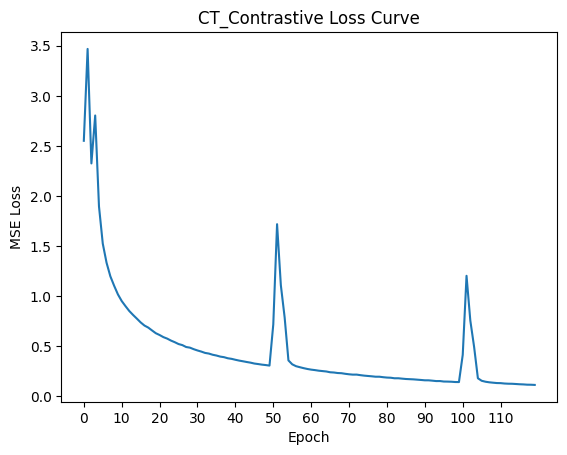

In [ ]:
# Define hyperparameters and instantiate model
batch_size    = 32
train_frac    = 50                 # fraction of training batches to include in each epoch
n_epoch       = 120
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CT_Contrastive(
    d_esm = 1280,
    d_model = 512,
    nhead = 8,
    dim_ff = 1024,
    num_transformer_blocks = 3,
    max_len = 101,
    use_first_fitness = True,
    dropout_rate = 0.1,
    conv_hidden_channels=[128, 256, 512],
    kernel_sizes=[7,3,3],
    strides=[2,2,2],
).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-6, weight_decay=1e-4)



# --- load & preprocess data ---
n_round = 3
train_idx1, train_idx2, train_fit1, train_lbl = [], [], [], []

emb_list = []
offset = 0
for r in [f'r{i}' for i in range(1, n_round+1)]:
    emb = np.load(f'/content/drive/MyDrive/Mid_1_data_train/ESM_emb_{r}.npy')
    emb_list.append(emb)
    seq2idx = pickle.load(open(f'/content/drive/MyDrive/Mid_1_data_train/seq_to_index_{r}.pkl','rb'))
    df_tr = pd.read_csv(f'/content/drive/MyDrive/Mid_1_data_train/data_contrastive_inference_{r}.csv').sample(frac=1, random_state=1).reset_index(drop=True)

    train_idx1 += [seq2idx[s.rstrip('*')]+offset for s in df_tr['seq_1']]
    train_idx2 += [seq2idx[s.rstrip('*')]+offset for s in df_tr['seq_2']]
    train_fit1 += [float(f) for f in df_tr['fitness_1']]
    train_lbl  += [float(y) for y in df_tr['label']]

    offset += emb.shape[0]
emb = np.concatenate(emb_list)




# --- training loop ---

train_losses = []

for epoch in range(1, n_epoch+1):
    tr_loss = train_epoch(model, optimizer,
        train_idx1, train_idx2,
        train_fit1, train_lbl,
        emb, batch_size, epoch, device, train_frac)
    train_losses.append(tr_loss)

    print(f"Epoch {epoch:3d} ▶ Train Loss {tr_loss:.4f}")

torch.save(model.state_dict(), "/content/drive/MyDrive/Mid_1_Contrast_results/CT_Contrastive_inference.pt")



# --- plot loss curve ---
epochs = range(len(train_losses))
ticks  = np.arange(0, len(train_losses), 10)

plt.figure()
plt.plot(epochs, train_losses)
plt.xticks(ticks)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title(f"CT_Contrastive Loss Curve")
plt.savefig("/content/drive/MyDrive/Mid_1_Contrast_results/CT_Contrastive_loss_inference.png")

# Inference on point mutations

In [ ]:
# 1) Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CT_Contrastive(
    d_esm = 1280,
    d_model = 512,
    nhead = 8,
    dim_ff = 1024,
    num_transformer_blocks = 3,
    max_len = 101,
    use_first_fitness = True,
    dropout_rate = 0.1,
    conv_hidden_channels=[128, 256, 512],
    kernel_sizes=[7,3,3],
    strides=[2,2,2],
).to(device)
checkpoint = "/content/drive/MyDrive/Mid_1_Contrast_results/CT_Contrastive_inference.pt"
model.load_state_dict(torch.load(checkpoint, map_location=device))
model.eval()

# 2) Prepare ESM-2 for embedding
esm_model_name = "facebook/esm2_t33_650M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(esm_model_name, do_lower_case=False)
esm = AutoModel.from_pretrained(esm_model_name).to(device)
esm.eval()


# 3) Build all point‐mutants of the reference seq
ref_seq = "MAGSDSPLAEQIKNTLTFIGQANAAGRMDEVRTLQKNLHPLWAEYFQLTEGSGGSPLAQQIQNGHVLIHQARAAGRMDEVRRLTEKTLQLMKEYFQQSD"
aas = list("ACDEFGHIKLMNPQRSTVWY")
start_idx = 5    # index start from 1

variants = []
mutations = []
L = len(ref_seq)
for i, wt in enumerate(ref_seq):
    if i < start_idx-1:
      continue
    for aa in aas:
        if aa == wt:
            continue
        var = ref_seq[:i] + aa + ref_seq[i+1:]
        variants.append(var)
        mutations.append(f"{wt}{i-3}{aa}")

# include the wild‐type itself
variants.insert(0, ref_seq)
mutations.insert(0, "")


# 4) Embed mid13sc once (padded/truncated to length 101 tokens)
max_len = len(ref_seq) + 2
with torch.no_grad():
    mid_toks = tokenizer(
        ref_seq,
        return_tensors="pt",
        padding="max_length",
        max_length=max_len,
        truncation=True,
        add_special_tokens=True
    ).to(device)
    mid_emb = esm(**mid_toks).last_hidden_state.squeeze(0)  # (101,1280)

# 5) Batch‐infer all variants
batch_size = 32
fit1_value = 8.666429599066408
results = []

for start in tqdm(range(0, len(variants), batch_size), desc="Inferring variants"):
    end = min(start + batch_size, len(variants))
    batch_seqs = variants[start:end]
    batch_muts = mutations[start:end]

    # tokenize & embed variants
    with torch.no_grad():
        toks = tokenizer(
            batch_seqs,
            return_tensors="pt",
            padding="max_length",
            max_length=max_len,
            truncation=True,
            add_special_tokens=True
        ).to(device)
        var_emb = esm(**toks).last_hidden_state       # (B, 101, 1280)

    # prepare emb1 = repeated mid_emb
    B = end - start
    emb1 = mid_emb.unsqueeze(0).repeat(B, 1, 1)       # (B, 101, 1280)
    emb2 = var_emb                                    # (B, 101, 1280)
    fit1 = torch.full((B, 1), fit1_value, device=device)  # (B,1)

    # predict
    with torch.no_grad():
        preds = model(emb1, emb2, fit1)               # (B,)

    for seq, mut, score in zip(batch_seqs, batch_muts, preds.cpu().numpy()):
        results.append({
            "sequence": seq,
            "mutation": mut,
            "predicted_improvement": score
        })

# 6) Rank & save
df_out = pd.DataFrame(results)
df_out = df_out.sort_values(
    "predicted_improvement",
    ascending=False
).reset_index(drop=True)

out_csv = "/content/drive/MyDrive/Mid_1_Contrast_results/mid13sc_point_mut_results_ct.csv"
df_out.to_csv(out_csv, index=False)
print(f"Saved {len(df_out)} variants to {out_csv}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Inferring variants: 100%|██████████| 57/57 [03:31<00:00,  3.71s/it]

Saved 1806 variants to /content/drive/MyDrive/Mid_1_Contrast_results/mid13sc_point_mut_results_ct.csv


# Find where the reference sequence is ranked

In [ ]:
df_out[df_out['mutation'] == '']

,sequence,mutation,predicted_improvement
412,MAGSDSPLAEQIKNTLTFIGQANAAGRMDEVRTLQKNLHPLWAEYF...,,-7.701926


# Inference on double/ triple mutations

In [ ]:
# 1) Load the previous single‐mutant results and pick top 30 (excluding wildtype)
df_single = pd.read_csv(
    "/content/drive/MyDrive/Mid_1_Contrast_results/mid13sc_point_mut_results_ct.csv"
)
# exclude the wild‐type entry which has empty mutation string
df_filtered = df_single[df_single['mutation'] != ""].reset_index(drop=True)
top30 = df_filtered.head(30)
mut_list = top30['mutation'].tolist()

# 2) Generate all doublet & triplet combinations (only if positions differ)
#    parse mutation strings like "M1D" → (ref_aa, pos, alt_aa)

mut_pattern = re.compile(r'^([A-Z])(\d+)([A-Z])$')

def parse_mut(mut_str):
    """
    Given a mutation string like "G50A", parse into:
      (0‐based position, new_amino_acid).
    According to the new scheme, the integer in the middle is offset by –3,
    so actual_index = int(number) + 3.
    """
    m = mut_pattern.match(mut_str)
    if m is None:
        raise ValueError(f"Unrecognized mutation format: {mut_str}")
    raw_num = int(m.group(2))
    actual_idx = raw_num + 3           # offset by –3 → +3 here
    new_aa = m.group(3)
    return (actual_idx, new_aa)



# Pre‐parse to tuples for fast checks
parsed = [parse_mut(m) for m in mut_list]
# Keep track of original mutation strings in same order
mutation_to_parsed = dict(zip(mut_list, parsed))

# Build valid combos
doublets = [
    combo for combo in itertools.combinations(mut_list, 2)
    if mutation_to_parsed[combo[0]][0] != mutation_to_parsed[combo[1]][0]
]
triplets = [
    combo for combo in itertools.combinations(mut_list, 3)
    if len({mutation_to_parsed[m][0] for m in combo}) == 3
]
all_combos = doublets + triplets

# 3) Apply mutations to the reference sequence
ref_seq = "MAGSDSPLAEQIKNTLTFIGQANAAGRMDEVRTLQKNLHPLWAEYFQLTEGSGGSPLAQQIQNGHVLIHQARAAGRMDEVRRLTEKTLQLMKEYFQQSD"


def apply_mutations(ref, muts):
    arr = list(ref)
    for mut in muts:
        pos, new_aa = mutation_to_parsed[mut]
        arr[pos] = new_aa
    return "".join(arr)

variants   = [apply_mutations(ref_seq, combo) for combo in all_combos]
mut_strs   = [",".join(combo) for combo in all_combos]


# 4) Load model & ESM embedder (assumes you ran the prior snippet)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Re‐load CT_Contrastive
model = CT_Contrastive(
    d_esm = 1280,
    d_model = 512,
    nhead = 8,
    dim_ff = 1024,
    num_transformer_blocks = 3,
    max_len = 101,
    use_first_fitness = True,
    dropout_rate = 0.1,
    conv_hidden_channels=[128, 256, 512],
    kernel_sizes=[7,3,3],
    strides=[2,2,2],
).to(device)
model.load_state_dict(torch.load(
    "/content/drive/MyDrive/Mid_1_Contrast_results/CT_Contrastive_inference.pt",
    map_location=device
))
model.eval()

# Re‐load ESM-2
from transformers import AutoTokenizer, AutoModel
esm_name = "facebook/esm2_t33_650M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(esm_name, do_lower_case=False)
esm = AutoModel.from_pretrained(esm_name).to(device)
esm.eval()

# Pre‐embed the reference once
max_len = len(ref_seq) + 2
with torch.no_grad():
    tok = tokenizer(
        ref_seq,
        return_tensors="pt",
        padding="max_length",
        max_length=max_len,
        truncation=True,
        add_special_tokens=True
    ).to(device)
    ref_emb = esm(**tok).last_hidden_state.squeeze(0)  # (101,1280)

# 5) Batch‐embed & predict all combos
batch_size = 32
fit1_value = 8.666429599066408
results = []

for i in tqdm(range(0, len(variants), batch_size), desc="Doublet/Triplet inference"):
    batch_seqs = variants[i:i+batch_size]
    batch_muts = mut_strs[i:i+batch_size]
    B = len(batch_seqs)

    # Tokenize + embed
    with torch.no_grad():
        toks = tokenizer(
            batch_seqs,
            return_tensors="pt",
            padding="max_length",
            max_length=max_len,
            truncation=True,
            add_special_tokens=True
        ).to(device)
        var_emb = esm(**toks).last_hidden_state  # (B,101,1280)

    # Prepare emb1, emb2, fit1
    emb1 = ref_emb.unsqueeze(0).repeat(B,1,1)         # (B,101,1280)
    emb2 = var_emb                                    # (B,101,1280)
    fit1 = torch.full((B,1), fit1_value, device=device)

    # Predict
    with torch.no_grad():
        preds = model(emb1, emb2, fit1).cpu().numpy()  # (B,)

    # Collect
    for seq, muts, score in zip(batch_seqs, batch_muts, preds):
        results.append({
            "sequence": seq,
            "mutations": muts,
            "predicted_improvement": score
        })

# 6) Rank & save
df_out = pd.DataFrame(results)
df_out = df_out.sort_values(
    "predicted_improvement",
    ascending=False
).reset_index(drop=True)

out_csv = "/content/drive/MyDrive/Mid_1_Contrast_results/mid13sc_doublet_triplet_results_ct.csv"
df_out.to_csv(out_csv, index=False)
print(f"Saved {len(df_out)} combined variants to {out_csv}")

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Doublet/Triplet inference: 100%|██████████| 129/129 [08:18<00:00,  3.86s/it]

Saved 4126 combined variants to /content/drive/MyDrive/Mid_1_Contrast_results/mid13sc_doublet_triplet_results_ct.csv
